# Lumen Data Science

PyTissue

Update or install important libraries

In [1]:
if False:
    !pip install -Uqq fastai
    !pip install -Uqq librosa

In [2]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
import re
import itertools
import matplotlib.pyplot as plot
sys.path.append('../')

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Label getters

In [3]:
path = Path("../Dataset/Dataset/IRMAS_Validation_Data/")
get_song_files = FileGetter(extensions='.wav', recurse=True)
files = get_song_files(path)
print(f"(#{len(files)})", files[:6])

(#2874) [Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-11.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-12.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-13.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-14.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-15.wav')]


In [4]:
def is_IRMAS_train(pat: Path):
    return str(pat).find("IRMAS_Training_Data") != -1

def is_IRMAS_valid(pat: Path):
    return str(pat).find("IRMAS_Validation_Data") != -1
    
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
is_IRMAS_train(song_path), is_IRMAS_valid(song_path)

(False, True)

In [5]:
def get_IRMAS_train_label(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []
song_path = Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__1.wav")
get_IRMAS_train_label(song_path)

['cel']

In [6]:
def get_IRMAS_valid_label(pat: Path):
    with open(os.path.splitext(str(pat))[0] + ".txt") as file:
        return file.read().split()
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_IRMAS_valid_label(song_path)

['gel', 'voi']

In [7]:
def get_label(pat: Path):
    if is_IRMAS_train(pat):
        return get_IRMAS_train_label(pat)
    if is_IRMAS_valid(pat):
        return get_IRMAS_valid_label(pat)
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_label(song_path)

['gel', 'voi']

## Get items

In [459]:
n_fft = 512  # 1024
hop_length = 256  # 512
f_min = 20
f_max = 8000
sample_rate = 44100

In [460]:
def get_song(pat: Path):
    return librosa.load(pat, sr=None)[0]

In [440]:
def clip_song(clip):
    aplen = sample_rate*3 - len(clip) + 1
    if aplen < 0: aplen = 0
    clip = np.concatenate([clip, np.zeros(aplen)])
    maxran = len(clip)-sample_rate*3
    if maxran <= 0: maxran = 1
    i = np.random.randint(maxran)
    clip = clip[i:i+sample_rate*3]
    return clip

In [499]:
def get_spec(clip):
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    return stft

In [521]:
def spec2mag(stft):
    stft_magnitude, _ = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    return stft_magnitude_db

In [522]:
def get_magspec(pat: Path):
    return spec2mag(get_spec(get_song(pat)))

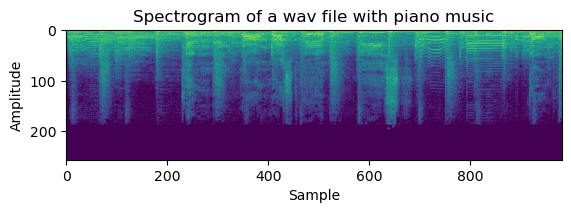

In [523]:
def plot_magspec(stft_magnitude_db):
    plot.title('Spectrogram of a wav file with piano music')
    plot.imshow(spec)
    plot.xlabel('Sample')
    plot.ylabel('Amplitude')
    
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
spec = get_magspec(song_path)
plot_magspec(spec)

## Creating metrics

In [23]:
def acc(x, y):
    return 1 - (((x > 0.5).float() - y).abs()).float().mean()
acc(torch.tensor([[0.1, 0.9, 0.4], [0.2, 0.2, 0.6]]), torch.tensor([[1, 1, 0], [0, 0, 1]]))

tensor(0.8333)

## Building the model

In [ ]:
def Combine(f_chain: List):
    def fun(x):
        for f in f_chain:
            x = f(x)
        return x
    return fun

In [123]:
path = Path("../Dataset/Dataset/IRMAS_Training_Data")

In [350]:
dls = DataBlock(
    blocks = [ImageBlock(), MultiCategoryBlock],
    get_items = get_song_files,
    splitter = RandomSplitter(),
    get_x = Combine([get_song, clip_song, get_spec, spec2mag]),
    get_y = get_label
).dataloaders(path, bs=64)

In [125]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
dls.train

7664
1915


In [126]:
learn = vision_learner(dls, resnet18, metrics=acc)

In [127]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,acc,time
0,0.689051,0.322809,0.904059,01:06


epoch,train_loss,valid_loss,acc,time
0,0.317259,0.240983,0.911607,01:18
1,0.246248,0.206100,0.921244,01:18
2,0.191099,0.180224,0.928222,01:19
3,0.152303,0.175434,0.930264,01:19


## Data splitters

In [154]:
from random import shuffle
def IRMAS_Splitter(IRMAS_valid_splitter=RandomSplitter(), IRMAS_train_splitter=RandomSplitter(0)):
    def splitter(paths: list[Path]):
        IRMAS_train = np.array([i for i, pat in enumerate(paths) if is_IRMAS_train(pat)])
        IRMAS_valid = np.array([i for i, pat in enumerate(paths) if is_IRMAS_valid(pat)])
        
        vTrain, vValid = IRMAS_valid_splitter(IRMAS_valid)
        tTrain, tValid = IRMAS_train_splitter(IRMAS_train)
        
        train = list(IRMAS_train[tTrain]) + list(IRMAS_valid[vTrain])
        valid = list(IRMAS_train[tValid]) + list(IRMAS_valid[vValid])
        
        shuffle(train)
        shuffle(valid)
        return train, valid
    return splitter

In [258]:
dls = DataBlock(
    blocks = [ImageBlock(), MultiCategoryBlock],
    get_items = get_song_files,
    get_x = Combine([get_song, get_spec, spec2mag]),
    get_y = get_label
).dataloaders(path, bs=64)

In [259]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
dls.train

9005
574


In [218]:
learn = vision_learner(dls, resnet18, metrics=acc)
learn.fine_tune(4)

epoch,train_loss,valid_loss,acc,time
0,0.617082,0.333623,0.873139,01:12


epoch,train_loss,valid_loss,acc,time
0,0.284795,0.292186,0.879949,01:25
1,0.221014,0.249011,0.896262,01:26
2,0.167776,0.227905,0.905765,01:26
3,0.130930,0.222329,0.908299,01:26


## Data augmentation

Combine two or more music files

In [306]:
from random import choice
def MultipleSongGetter(paths: List, w=None, n=1000, s=0.5):
    def multiple_getter(p=None):
        fg = FileGetter(extensions='.wav', recurse=True)
        song_paths = [fg(pat) for pat in paths]

        def gs():
            i = np.random.choice(list(range(len(paths))), p=w)
            return choice(song_paths[i])

        lens = np.random.poisson(s, n)+1
        return [[gs() for j in range(l)] for l in lens]
    return multiple_getter
MultipleSongGetter([path])()[:3]

[[Path('../Dataset/Dataset/IRMAS_Validation_Data/Telefon Tel Aviv - Helen of Troy-9.wav')],
 [Path('../Dataset/Dataset/IRMAS_Validation_Data/keith jarrett - arbour zena - 01 - runes-18.wav')],
 [Path('../Dataset/Dataset/IRMAS_Validation_Data/05 - Sonata in A minor, Op. post. 143 D.784 - I. Allegro giusto-17.wav')]]

In [301]:
from IPython.display import Audio
x = get_song(Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__3.wav"))
y = get_song(Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0002__3.wav"))
z = 0.5*(x + y)

Audio(data=z, rate=sample_rate)

In [19]:
def AddSongs(gs, s=0.5, lim=0.5):
    def add_songs(t):
        songs = [gs(pat) for pat in t]
        ran = np.random.normal(1, s, len(songs))
        ran[np.where((ran > 1+lim) | (ran < 1-lim))] = 1
        return sum(s*r for s, r in zip(songs, ran))
    return add_songs

In [21]:
song_1 = Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0002__3.wav")
song_2 = Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__3.wav")
z = AddSongs(get_song, 0.5, 0.7)([song_1, song_2])

Audio(data=z, rate=sample_rate)

In [22]:
def AddLabels(gl):
    def add_labels(files: List[Path]):
        return list(set([l for pat in files for l in gl(pat)]))
    return lambda t: add_labels(t)
song_1 = Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__3.wav")
song_2 = Path("../Dataset/Dataset/IRMAS_Training_Data/flu/[flu][cla]0346__1.wav")
AddLabels(get_label)([song_1, song_2])

['cel', 'flu']

## New dataloaders

In [572]:
def tfm(s):
    return s

sdbl = DataBlock(
    blocks = [DataBlock(blocks=[ImageBlock()]), MultiCategoryBlock],
    n_inp = 1,
    get_items = MultipleSongGetter([path], n=8000),
    splitter = RandomSplitter(),
    get_x = Combine([AddSongs(Combine([get_song, clip_song, get_spec, spec2mag]))]),
    get_y = AddLabels(get_label),
    batch_tfms=tfm
)

In [573]:
dls = sdbl.dataloaders(path, bs=64)

TypeError: 'L' object is not callable

In [ ]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
dls.train

In [ ]:
# sdbl.summary(path)
print(dls.vocab)
# dls.train.show_batch()

## Building the model

In [ ]:
learn = vision_learner(dls, resnet18, metrics=acc)

In [ ]:
learn.fine_tune(1)

## Track GPU usage

In [380]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, 1, 0)

In [381]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

In [382]:
import gc
def report_gpu():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    gc.collect()
    torch.cuda.empty_cache()

In [383]:
report_gpu()

Memory Usage:
Allocated: 0.0 GB
Cached:    0.2 GB


## Gradient Accumulation

In [ ]:
def train(arch, accum=1, finetune=True, epochs=12, bs=64):
    _dls = DataBlock(
        blocks = [ImageBlock(), MultiCategoryBlock],
        get_items = get_song_files,
        splitter = RandomSplitter(),
        get_x = get_magspec,
        get_y = get_label
    ).dataloaders(path, bs=bs)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(_dls, arch, metrics=acc, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        # return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [ ]:
# train(resnet18, epochs=6)